## loading zfp-compressed cm1 arrays with yt

zfp is an open-source compression library (1) that has been used by lofs (2) to efficiently compress CM1 cloud model output (3, 4). yt (5), the open source python analysis and visualization package, recently added support for lofs-cm1 netcdf files without zfp-compression. This notebook starts off demonstrating the changes needed for the yt cm1 frontend to load the zfp-compressed data. It then explores using some of the new features of yt 4.1.0 with cm1 data. 


**References**

(1) https://computing.llnl.gov/projects/zfp
(2) http://lofs.io/index.php?title=Main_Page
(3) https://www.mdpi.com/2073-4433/10/10/578
(4) http://orf.media/wp-content/uploads/2017/12/agu2017-orf.pdf
(5) https://yt-project.org, others. 


**Requirements**
This notebook has the following requirements:

In [2]:
for req_file in ["requirements.txt", "requirements_manual.txt", "requirements_supplemental.txt"]:
    with open(req_file,"r") as fi:
        for req in fi.readlines():
            print(req.strip())

zfpy
h5py
netCDF4
hdf5plugin
yt>=4.1.0
memray
pandas
jupyterlab


note that at the time of writing, yt version 4.1.0 is not yet released and so must be compiled from source. The `memray` and `pandas` requirements are only for the final performance analysis (and memray is not actually required to run this notebook as the memray results are stored in the repository).  

**Sample Data**

This notebook relies on a ~9GB cm1 simulation output as netcdf files via lofs with zfp compression. Timesteps are stored as individual `.nc` files and are just under 1GB each.

### manual loading 

Before leveraging yt, it's worth investigating the files directly. We can do so with either `h5py` or `netCDF4`, but in either case, we need to import the `hdf5plugin` package so that the `zfp` can be found:

In [8]:
import netCDF4 
import hdf5plugin  
import numpy as np
from yt.sample_data.api import lookup_on_disk_data

fullfi = lookup_on_disk_data("cm1_zfp_compressed/mkow075-ens-db620.00790800.nc")
with netCDF4.Dataset(fullfi) as ds: 
    dbz = ds.variables['dbz']
    print(dbz.dimensions)
    print(dbz.shape)
    print(dbz.shape[1:])
    print(np.mean(dbz))

('time', 'zh', 'yh', 'xh')
(1, 232, 996, 1096)
(232, 996, 1096)
-13.904157


### loading with the yt nc_cm1 frontend

The only additional step to loading the zfp-compressed data is to ensure the `hdf5plugin` package is imported before loading as usual. 

In [9]:
import hdf5plugin
import yt
ds = yt.load("cm1_zfp_compressed/mkow075-ens-db620.00790800.nc")
ds

yt : [INFO     ] 2022-10-04 16:56:40,367 Parameters: current_time              = 7908.0
yt : [INFO     ] 2022-10-04 16:56:40,368 Parameters: domain_dimensions         = [1096  996  232]
yt : [INFO     ] 2022-10-04 16:56:40,369 Parameters: domain_left_edge          = [-37.38750076 -29.88750076   0.0375    ]
yt : [INFO     ] 2022-10-04 16:56:40,370 Parameters: domain_right_edge         = [44.73749924 44.73749924 17.36249924]
yt : [INFO     ] 2022-10-04 16:56:40,370 Parameters: cosmological_simulation   = 0


CM1Dataset: /home/chavlin/hdd/data/yt_data/yt_sample_sets/cm1_zfp_compressed/mkow075-ens-db620.00790800.nc

In [31]:
def set_cmap_prefs(yt_plot, field, cmap_name, cmap_limits):
    yt_plot.set_log(field, False)
    yt_plot.set_cmap(field, cmap_name)
    yt_plot.set_zlim(field, cmap_limits[0], cmap_limits[1])

yt : [INFO     ] 2022-10-04 17:10:15,868 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:10:15,869 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:10:15,869 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:10:15,870 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:10:15,871 Making a fixed resolution buffer of (('cm1', 'dbz')) 800 by 800



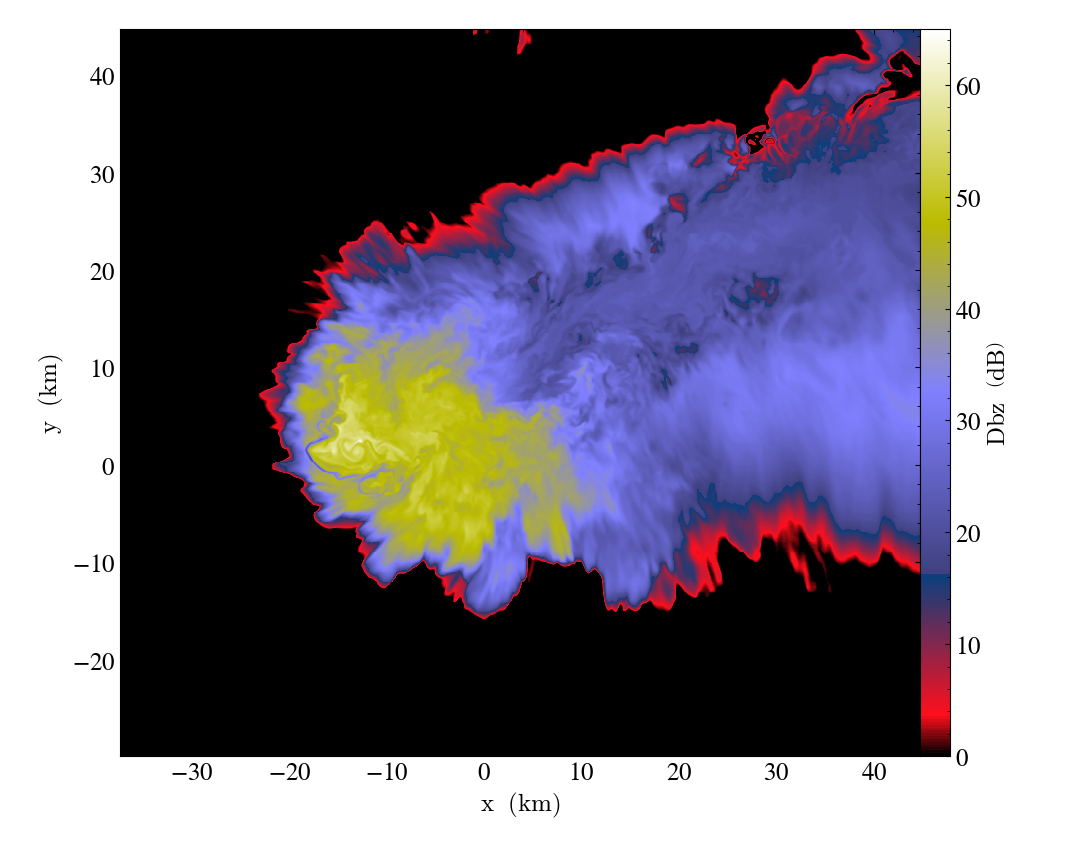

In [30]:
field = ("cm1", "dbz")
slc = yt.SlicePlot(ds, "z", field, origin="native")
set_cmap_prefs(slc, field, "gist_stern", (0., 65.))
slc.show()

yt : [INFO     ] 2022-10-04 17:10:46,040 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:10:46,041 ylim = 0.037500 17.362499
yt : [INFO     ] 2022-10-04 17:10:46,042 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:10:46,042 ylim = 0.037500 17.362499
yt : [INFO     ] 2022-10-04 17:10:46,043 Making a fixed resolution buffer of (('cm1', 'dbz')) 800 by 800



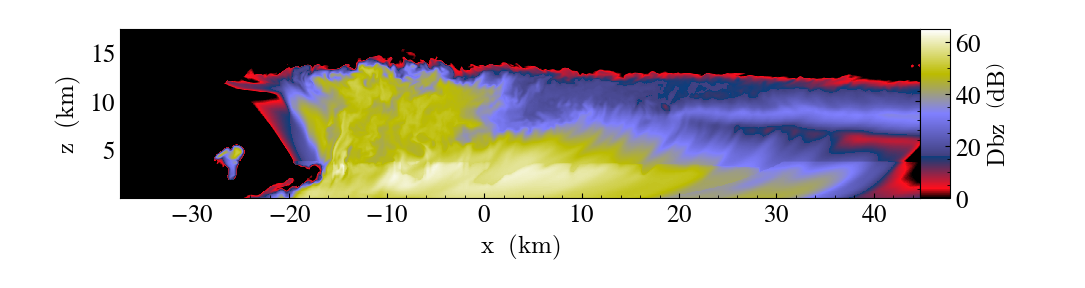

In [32]:
slc = yt.SlicePlot(ds, "y", field, origin="native")
set_cmap_prefs(slc, field, "gist_stern", (0., 65.))
slc.show()

In the following, we'll focus the plots on the plane containing the max `dbz` value, so let's first pull out the location of the max:

In [16]:
ad = ds.all_data()
max_val, d0, d1, d2 = ad.quantities.max_location(field)
center = ds.arr([d0, d1, d2])
center.to('km')

unyt_array([-15.91960615,   3.86607604,   3.95802785], 'km')

let's first plot a plane normal to z through the location of the maximum value and covering the whole domain:

yt : [INFO     ] 2022-10-04 17:11:42,449 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:11:42,450 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:11:42,451 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:11:42,451 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:11:42,452 Making a fixed resolution buffer of (('cm1', 'dbz')) 800 by 800



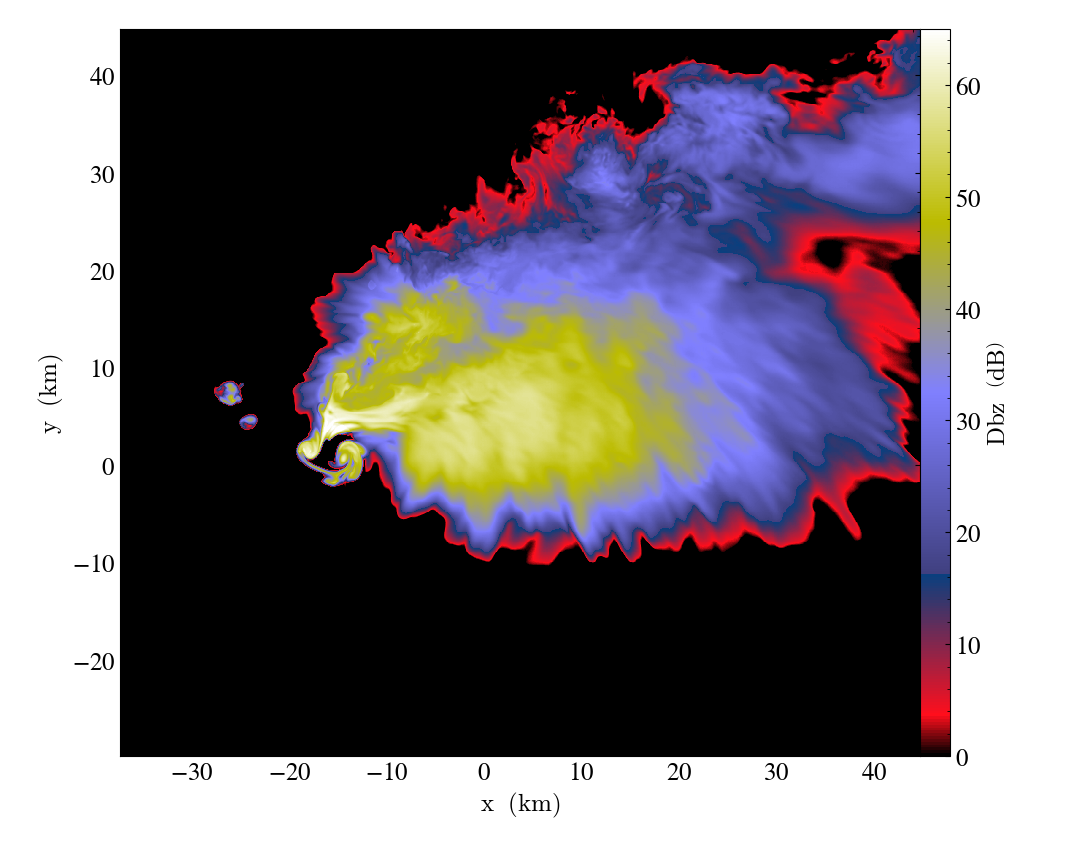

In [33]:
c = ds.domain_center
c[2] = center[2]
slc = yt.SlicePlot(ds, "z", field, origin="native", center=c)
set_cmap_prefs(slc, field, "gist_stern", (0., 65.))
slc.show()

and let's now center the whole plot on the location of the max value and zoom in:

yt : [INFO     ] 2022-10-04 17:12:11,312 xlim = -30.919606 -0.919606
yt : [INFO     ] 2022-10-04 17:12:11,313 ylim = -11.133924 18.866076
yt : [INFO     ] 2022-10-04 17:12:11,313 xlim = -30.919606 -0.919606
yt : [INFO     ] 2022-10-04 17:12:11,314 ylim = -11.133924 18.866076
yt : [INFO     ] 2022-10-04 17:12:11,315 Making a fixed resolution buffer of (('cm1', 'dbz')) 800 by 800



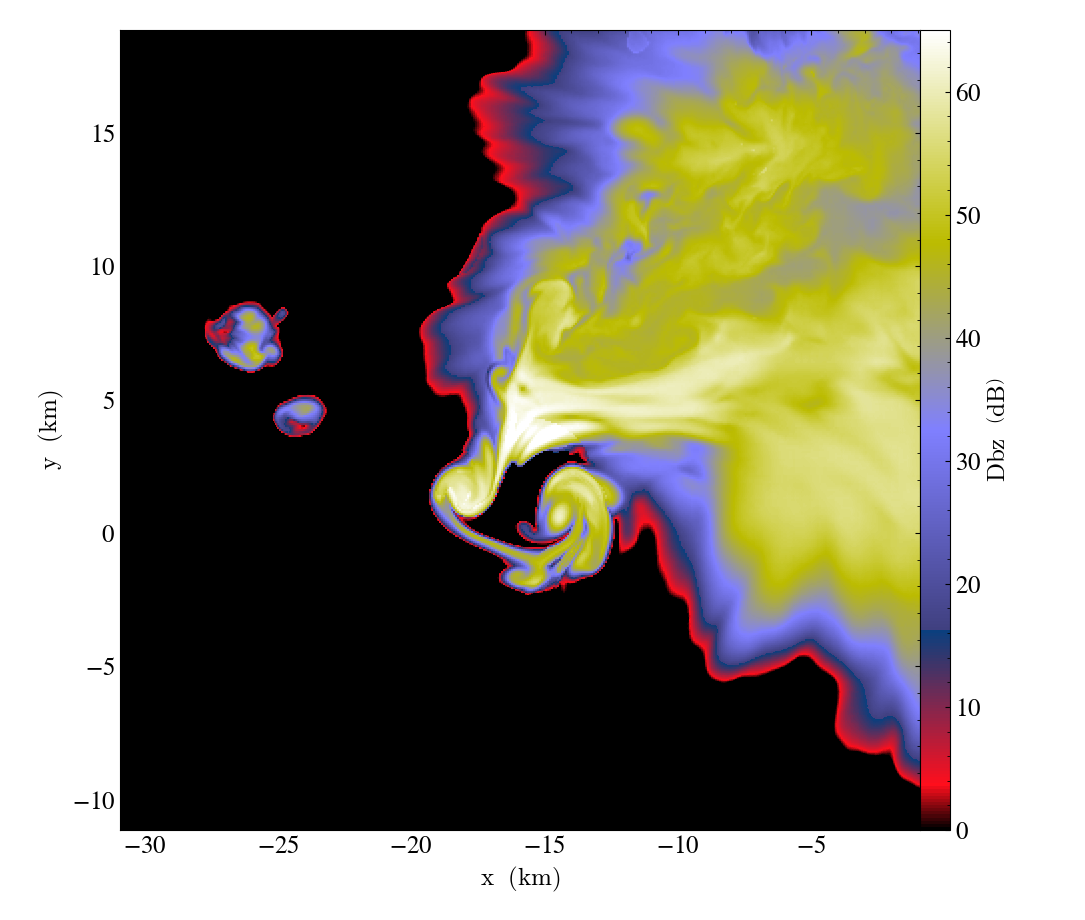

In [34]:
slc = yt.SlicePlot(ds, "z", field, center=center, origin="native", width=(30, "km"))
set_cmap_prefs(slc, field, "gist_stern", (0., 65.))
slc.show()

yt : [INFO     ] 2022-10-04 17:21:48,439 xlim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:21:48,439 ylim = 0.037500 17.362499
yt : [INFO     ] 2022-10-04 17:21:48,440 xlim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:21:48,440 ylim = 0.037500 17.362499
yt : [INFO     ] 2022-10-04 17:21:48,441 Making a fixed resolution buffer of (('cm1', 'vortmag')) 800 by 800



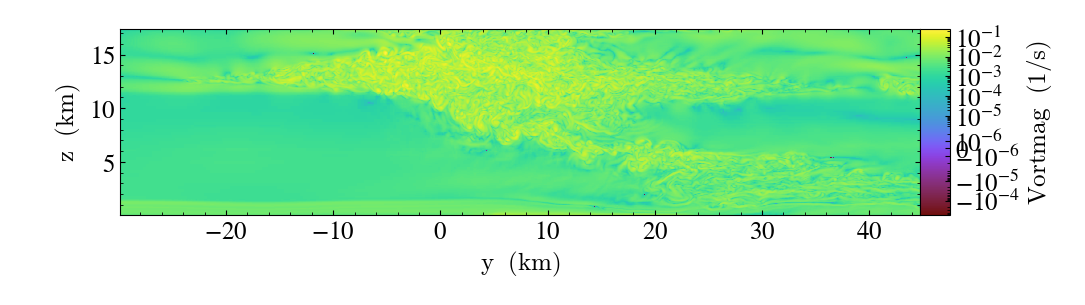

yt : [INFO     ] 2022-10-04 17:21:51,807 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:21:51,808 ylim = 0.037500 17.362499
yt : [INFO     ] 2022-10-04 17:21:51,808 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:21:51,808 ylim = 0.037500 17.362499
yt : [INFO     ] 2022-10-04 17:21:51,810 Making a fixed resolution buffer of (('cm1', 'vortmag')) 800 by 800



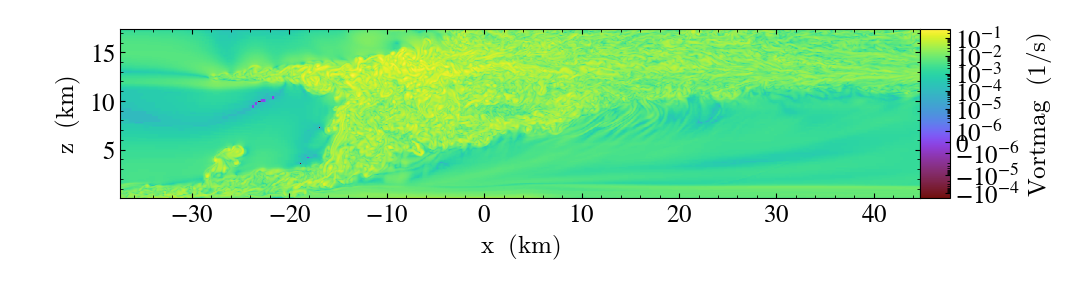

yt : [INFO     ] 2022-10-04 17:21:55,168 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:21:55,168 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:21:55,169 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:21:55,169 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:21:55,170 Making a fixed resolution buffer of (('cm1', 'vortmag')) 800 by 800



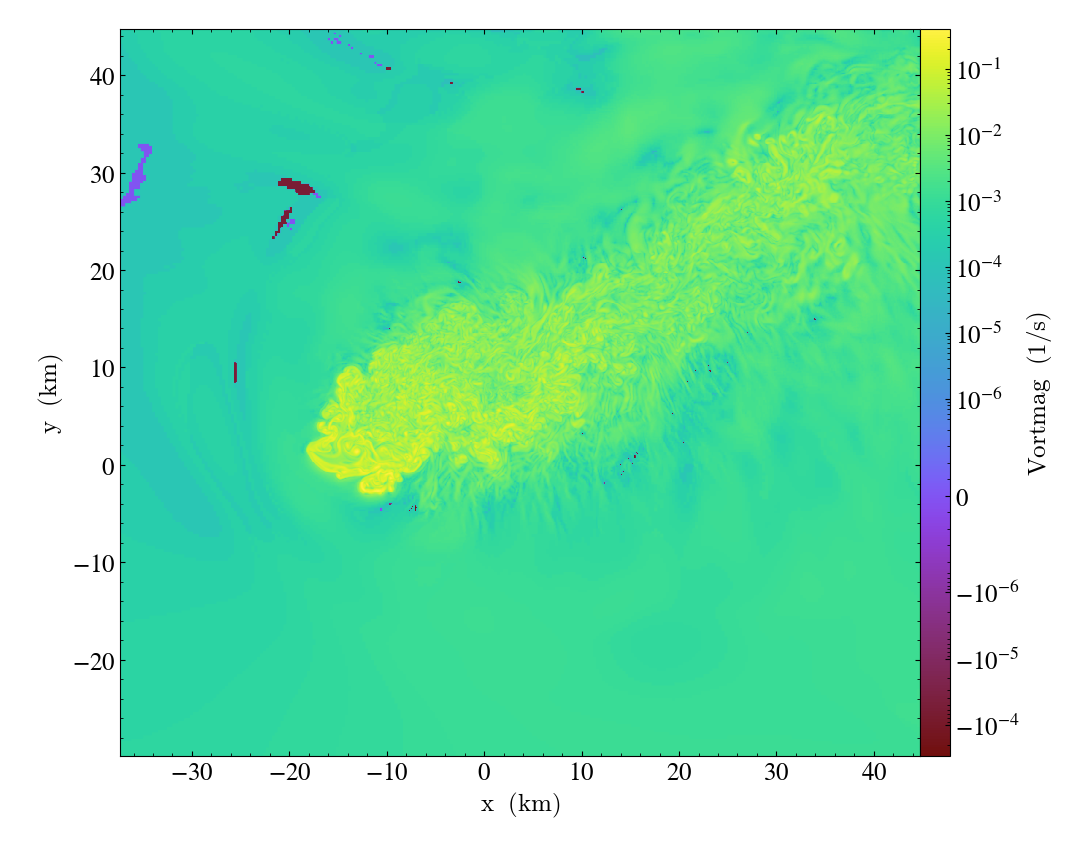

In [52]:
fld = ("cm1", "vortmag")
for dim in ["x", "y", "z"]:
    slc = yt.SlicePlot(ds, dim, fld, origin="native")
    # slc.set_log(fld, False)
    slc.show()

yt : [INFO     ] 2022-10-04 17:20:48,096 Projection completed
yt : [INFO     ] 2022-10-04 17:20:48,096 xlim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:20:48,096 ylim = 0.037500 17.362499
yt : [INFO     ] 2022-10-04 17:20:48,097 xlim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:20:48,098 ylim = 0.037500 17.362499
yt : [INFO     ] 2022-10-04 17:20:48,099 Making a fixed resolution buffer of (('cm1', 'vortmag')) 800 by 800



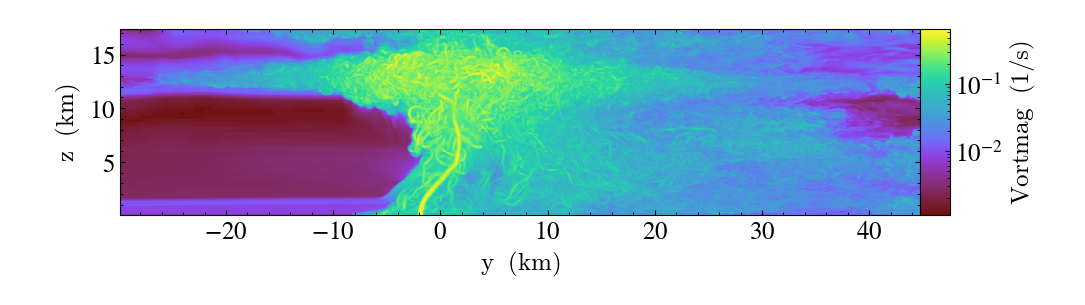

yt : [INFO     ] 2022-10-04 17:21:00,403 Projection completed
yt : [INFO     ] 2022-10-04 17:21:00,404 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:21:00,404 ylim = 0.037500 17.362499
yt : [INFO     ] 2022-10-04 17:21:00,404 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:21:00,405 ylim = 0.037500 17.362499
yt : [INFO     ] 2022-10-04 17:21:00,406 Making a fixed resolution buffer of (('cm1', 'vortmag')) 800 by 800



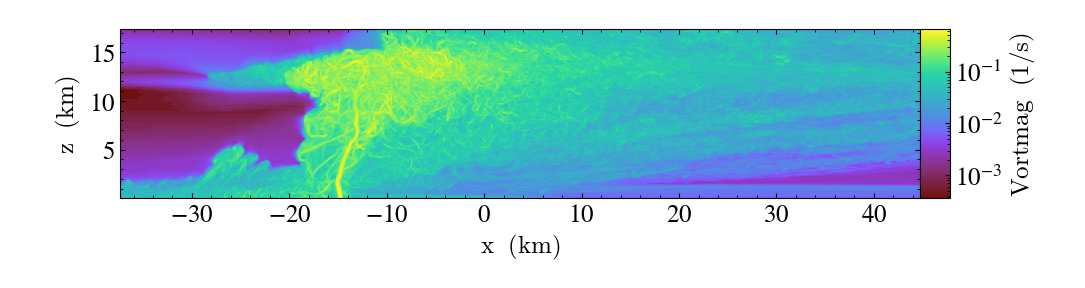

yt : [INFO     ] 2022-10-04 17:21:13,107 Projection completed
yt : [INFO     ] 2022-10-04 17:21:13,107 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:21:13,107 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:21:13,108 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:21:13,108 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:21:13,110 Making a fixed resolution buffer of (('cm1', 'vortmag')) 800 by 800



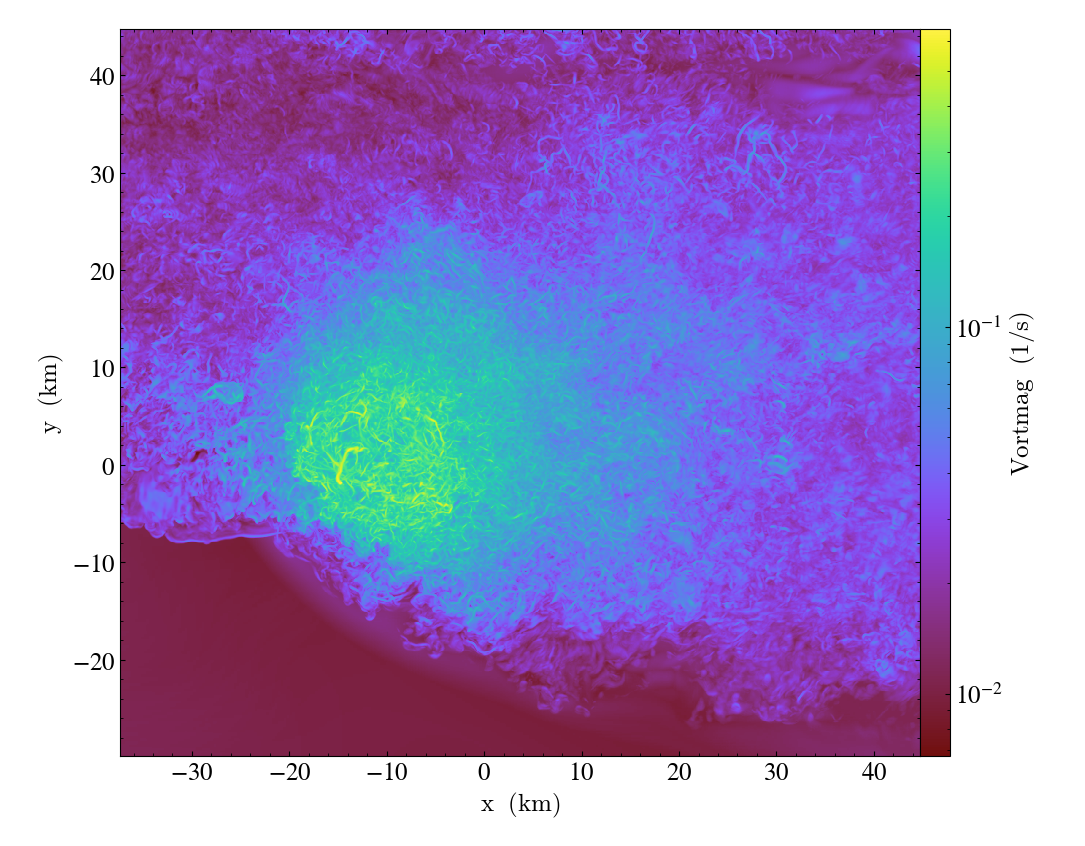

In [51]:
fld = ("cm1", "vortmag")
for dim in ["x", "y", "z"]:
    prj = yt.ProjectionPlot(ds, dim, fld, origin="native", method = "max")
    # slc.set_log(fld, False)
    prj.show()

### loading with yt's new stream functionality 

One of the new features in yt is the abilitiy to load gridded datasets by providing a callable that specifies how to load data for a subset of the domain. Compared to the full `nc_cm1` frontent, using the calalble functionality allows only subsections of the full array to be processed. The new `yt.load_hdf5_file` wraps this new functionality nicely, but since the data arrays here are 4-dimensional, we need to adjust that function.

The following is an exact copy/paste, with the exception that within the callable, we add an extra slice to remove the time-dimension and we adjust the bounding box calculation to pull out the expected dimensions.

In [53]:
import h5py 
import yt 
import hdf5plugin
from yt.sample_data.api import lookup_on_disk_data
from yt.utilities.decompose import decompose_array, get_psize
from yt.utilities.logger import ytLogger as mylog
from typing import Optional, Union, List 
import numpy as np


def load_cm1_zfp(
    fn: Union[str, "os.PathLike[str]"],
    root_node: Optional[str] = "/",
    fields: Optional[List[str]] = None,
    bbox: np.ndarray = None,
    nchunks: int = 0,
    dataset_arguments: Optional[dict] = None,
):
    
    dataset_arguments = dataset_arguments or {}    

    def _read_data(handle, root_node):
        def _reader(grid, field_name):
            ftype, fname = field_name
            si = grid.get_global_startindex()
            ei = si + grid.ActiveDimensions
            return handle[root_node][fname][0, si[0] : ei[0], si[1] : ei[1], si[2] : ei[2]]

        return _reader

    fn = str(lookup_on_disk_data(fn))
    handle = h5py.File(fn, "r")
    
    if bbox is None:
        bbox = []
        dbz_shape = []
        for dim in ["zh", "yh", "xh"]: 
            bbox.append([np.min(handle[dim]), np.max(handle[dim])])
        bbox = np.array(bbox)
        mylog.info(f"calculated bounding box, {bbox}")
        # bbox = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])
        # mylog.info("Assuming unitary (0..1) bounding box.")
    
    reader = _read_data(handle, root_node)
    if fields is None:
        fields = list(handle[root_node].keys())
        mylog.debug("Identified fields %s", fields)
    shape = handle[root_node][fields[0]].shape[1:]
    if nchunks <= 0:
        # We apply a pretty simple heuristic here.  We don't want more than
        # about 64^3 zones per chunk.  So ...
        full_size = np.prod(shape)
        nchunks = full_size // (64**3)
        mylog.info("Auto-guessing %s chunks from a size of %s", nchunks, full_size)
    grid_data = []
    psize = get_psize(np.array(shape), nchunks)
    left_edges, right_edges, shapes, _ = decompose_array(shape, psize, bbox)
    for le, re, s in zip(left_edges, right_edges, shapes):
        data = {_: reader for _ in fields}
        data.update({"left_edge": le, "right_edge": re, "dimensions": s, "level": 0})
        grid_data.append(data)
    return yt.load_amr_grids(grid_data, shape, bbox=bbox, **dataset_arguments)

In [55]:
fname = "cm1_zfp_compressed/mkow075-ens-db620.00790800.nc"
ds_args = dict(geometry=("cartesian", ("z", "y", "x")),
               length_unit="km")
ds = load_cm1_zfp(fname, 
                  fields=["dbz", "vortmag"],
                  nchunks=10,
                  dataset_arguments = ds_args)

yt : [INFO     ] 2022-10-04 17:32:11,292 calculated bounding box, [[ 3.75000e-02  1.73625e+01]
 [-2.98875e+01  4.47375e+01]
 [-3.73875e+01  4.47375e+01]]
yt : [INFO     ] 2022-10-04 17:32:11,355 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-10-04 17:32:11,356 Parameters: domain_dimensions         = [ 232  996 1096]
yt : [INFO     ] 2022-10-04 17:32:11,356 Parameters: domain_left_edge          = [  0.0375     -29.88750076 -37.38750076]
yt : [INFO     ] 2022-10-04 17:32:11,357 Parameters: domain_right_edge         = [17.36249924 44.73749924 44.73749924]
yt : [INFO     ] 2022-10-04 17:32:11,357 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2022-10-04 17:32:43,704 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:32:43,704 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:32:43,705 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-04 17:32:43,706 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-04 17:32:43,708 Making a fixed resolution buffer of (('stream', 'dbz')) 800 by 800



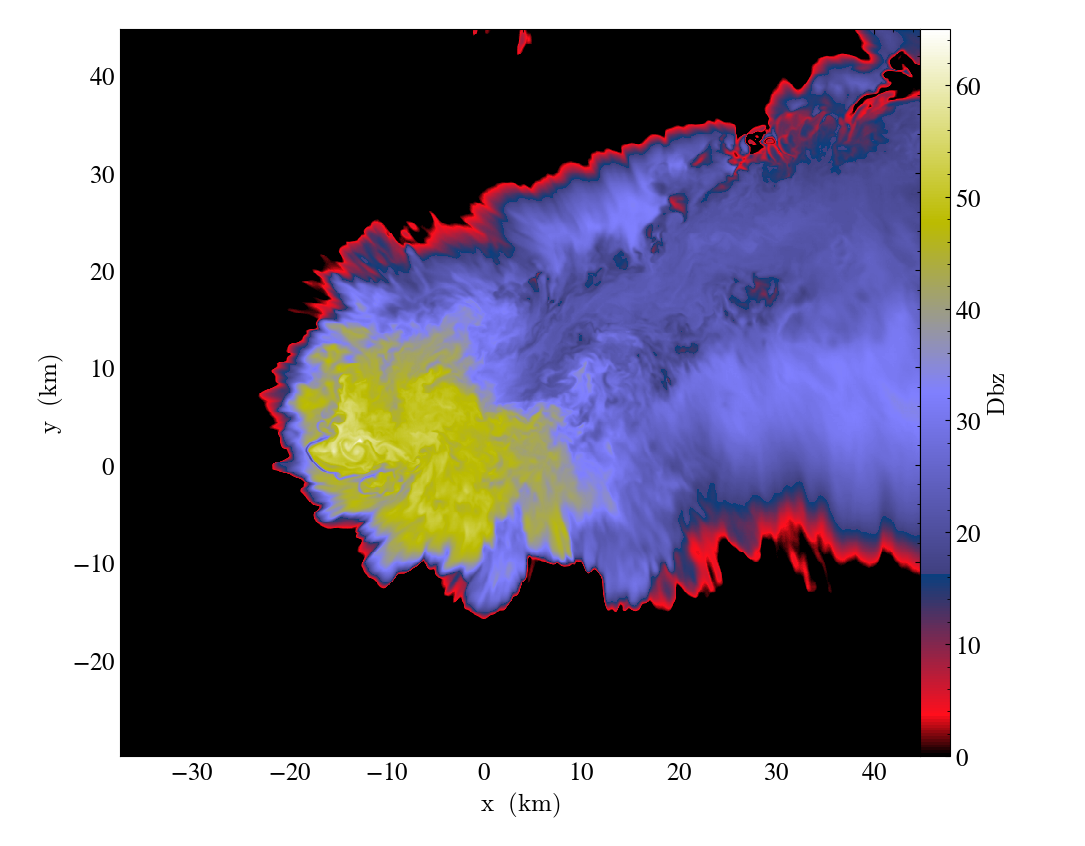

In [56]:
field = ("stream", "dbz")
slc = yt.SlicePlot(ds, "z", field, origin="native")
set_cmap_prefs(slc, field, "gist_stern", (0., 65.))
slc.show()

### performance comparison 



To compare the full `nc_cm1` frontend to the stream callable method, we wrote a test script, `test_load_method.py` that varies the load method and for the callable method accepts the number of chunks to use in decompising the yt grid structures. For each test case, the code will load the dataset and plot a slice through `dbz`. We used memray to monitor memory usage and ran the callable method for 2, 10, 50, 100 and 966 (966 chunks is what yt decomposes the grid into automatically). 

The full frontend exhibits large memory requirements, with a peak usage of 2.6 GB. 

The following table and plots show the peak usage by number of chunks for the callable method:


In [75]:
import pandas as pd 
df = pd.read_csv('callable_tests.csv')
df

nchunks  peak_usage_MB
0        2         1000.0
1       10          613.7
2       50          487.4
3      100          487.6
4      966          451.3

Text(0.5, 0, 'nchunks')

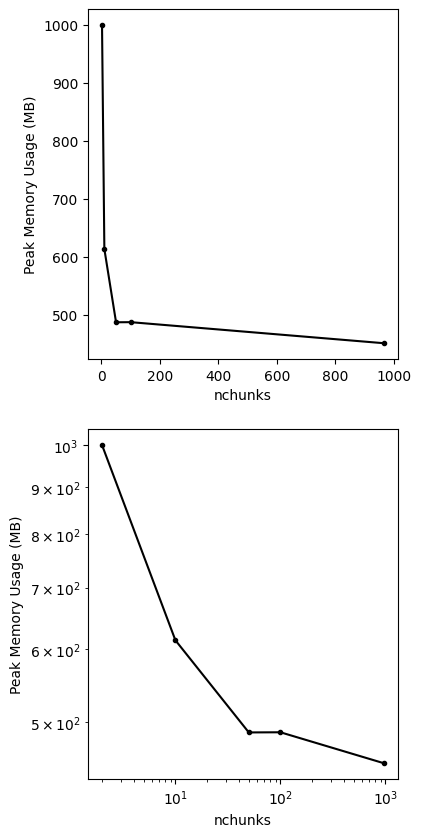

In [86]:
import matplotlib.pyplot as plt 
f,axs = plt.subplots(nrows=2,ncols=1, figsize=(4,10))
axs[1].loglog(df.nchunks, df.peak_usage_MB, marker=".", color="k")
axs[1].set_ylabel("Peak Memory Usage (MB)")
axs[1].set_xlabel("nchunks")

axs[0].plot(df.nchunks, df.peak_usage_MB, marker=".", color="k")
axs[0].set_ylabel("Peak Memory Usage (MB)")
axs[0].set_xlabel("nchunks")

memray's "Resident set size over time" plot, available in the flamegraph html output is particularly interesting. 

The following shows the resident and heap sizes for the full frontend over time:

### full frontend 
![full_frontend](./memray_resident_set_frontend.png)



### callable method 

And the corresponding plots for the callable methods with 2, 10, and 100 chunks are 

**nchunks=2**

![callable_2](./memray_resident_set_callable_0_2.png)

**nchunks=10**

![callable_10](./memray_resident_set_callable_0_10.png)

**nchunks=100**

![callable_100](./memray_resident_set_callable_0_100.png)

